# DBSCAN

Our work is based on $\href{https://www.aaai.org/Papers/KDD/1996/KDD96-037.pdf}{this}$ paper.

According to the algorithm each point in dataset can have three states: _unclassified_, _noise_ and _classified_.
By the end all points belong to some cluster or are considered noise.

The algorithm has 2 hyperparameters: __value of epsilon__ for epsilon-neighbourhood(epsN) of a point and __min number of points in epsN(minPts)__ to be not considered as _noise_.
 
Core notion in this algorithm is _direct density reachability_ of 2 points which is the following:
points $p$ and $q$ are considered _directly density reachable_ if:

1) $p$ belongs to epsilon-neighbourhood of $q$

2) number of points in epsilon-neighbourhood of $q$ is greater than some value

Clusters are created out of point's epsilon-neighbourhood(epsN) and expanded by epsilon-neighbourhoods of its(epsN) points, which can be imagined as many circles of same radius with centers in different points which expand cluster area

If _direct density reachability_ is not satified for some point moving of cluster into that direction stops. If it happens for all the points in epsN of some point the cluster is formed and another cluster begins expansion

## Implementation

In our implementation we used __numpy__ library for operations with data which reduced number of _if-conditions_ and _for-loops_ origially present in the paper

We used OOP appoach and represented algorithm as as class, which is more common.

Class methods mostly correspond to those functions stated in the paper

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

from collections import deque

In [2]:
class DBSCAN(object):
    """
    DBSCAN clustering algorithm implementation
    """
    UNCLASSIFIED = -2
    NOISE = -1
    
    def __init__(self, eps=0.5, min_pts=5):
        """
        eps: epsilon value for epsilon-neighbourhood
        min_pts: number of points in neighbourhood to be considered as epsilon-neighbourhood
        """
        self.eps = eps
        self.min_pts = min_pts

    def fit_predict(self, X):
        """
        X: data, numpy array of points
        return: array of cluster indices for points and noises
        """
        labels = np.full([X.shape[0]], DBSCAN.UNCLASSIFIED)
        return self._fit_predict(X, labels)

    def _fit_predict(self, X, labels):
        """
        Go through points in dataset and classify(set cluster id) them unless they are classified
        """
        cluster_id = DBSCAN._next_id(DBSCAN.NOISE)
        for point_ind in range(X.shape[0]):
            if labels[point_ind] == DBSCAN.UNCLASSIFIED and self._expand_cluster(X, labels, point_ind, cluster_id):
                #if self._expand_cluster(X, labels, point_ind, cluster_id):
                cluster_id = DBSCAN._next_id(cluster_id)
        return labels

    def _expand_cluster(self, X, labels, point_ind, cluster_id):
        """
        Add points to given cluster(cluster_id) if they are directly density reachable to given point(point_ind)
        """
        # find epsilon-neighbourhood of given point and add them to given cluster
        # otherwise classify them as noise
        region_inds = self._region_query(X, point_ind)
        if len(region_inds) < self.min_pts:
            labels[point_ind] = DBSCAN.NOISE
            return False

        # label these points to cluseter_id
        labels[region_inds] = cluster_id
        labels[point_ind] = cluster_id

        # create queue of points in the epsilon-neighbourhood
        # consider all points in the queue to possibly belong to cluster
        # detemine it testing direct density reachability
        queue_inds = deque(region_inds)
        while len(queue_inds):
            current_point_ind = queue_inds.popleft()

            result = self._region_query(X, current_point_ind)
            # test density reachability
            # on positive - consider only unclassified points and noises
            if len(result) > self.min_pts:
                is_noise = labels[result] == DBSCAN.NOISE
                is_unclassified = labels[result] == DBSCAN.UNCLASSIFIED
                
                # add only unclassified points
                queue_inds.extend(result[is_unclassified])
                # label these points to cluster_id
                labels[result[np.logical_or(is_noise, is_unclassified)]] = cluster_id
        return True

    def _region_query(self, X, point_ind):
        """
        Find epsilon-neighbourhood of a given point(point_ind)
        """
        d = np.sqrt(np.sum((X - X[point_ind]) ** 2, axis=1))
        mask = d < self.eps
        mask[point_ind] = False  # exclude this point
        return np.where(mask)[0]

    @staticmethod
    def _next_id(cluster_id):
        return cluster_id + 1


## Testing

For evaluating the results we use visual inspection (same as in the paper) on datasets from _scikit-learn_.

For visualization we use __matlotlib__

We tweak __value of epsilon__ hyperparameter of DBSCAN, remaining __minPts__ constant. We do that for every dataset separately to achieve the best results on each of them


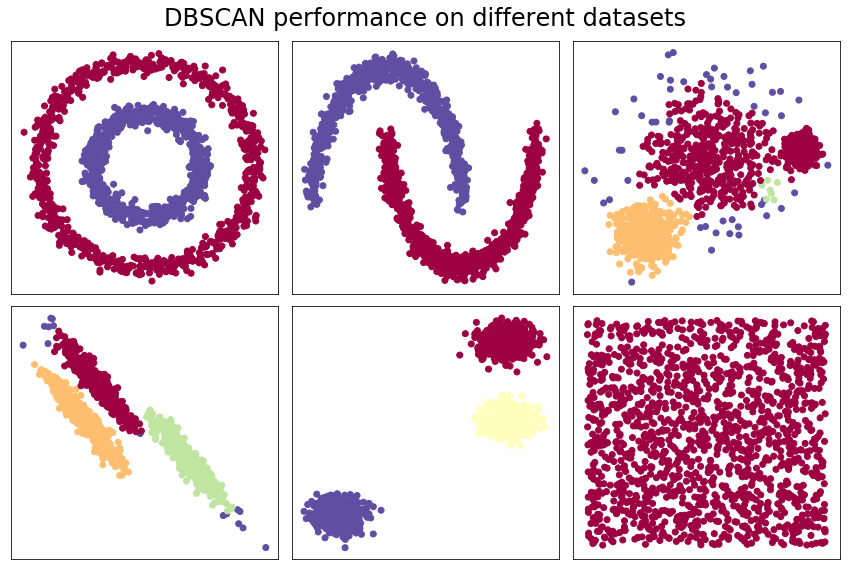

In [3]:
n_samples = 1500

noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.05)[0]
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)[0]
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)[0]

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = X_aniso

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)[0]

no_structure = np.random.rand(n_samples, 2)

data = [
    (noisy_circles, {'eps': 0.15}),
    (noisy_moons, {'eps': 0.2}),
    (varied, {'eps': .75}),
    (aniso, {'eps': .365}),
    (blobs, {'eps': 1.5}),
    (no_structure, {'eps': 0.3})
]

plt.figure(figsize=(12, 8))
plt.subplots_adjust(left=.02, right=.98, bottom=.02, top=.92, wspace=.05, hspace=.05)
plt.suptitle("DBSCAN performance on different datasets", fontsize=24)

for i in range(len(data)):
    dataset, conf = data[i][0], data[i][1]

    dbscan = DBSCAN(**conf)
    labels = dbscan.fit_predict(dataset)

    unique_labels = np.unique(labels)
    colors = np.array([plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels + 1))])

    ax = plt.subplot(2, 3, i + 1)
    plt.scatter(dataset[:, 0], dataset[:, 1], color=colors[labels])
    plt.xticks(())
    plt.yticks(())
plt.show()

In conclusion, __DBSCAN__ algorithm in our implementatin works perfectly on 5 out of 6 datasets(1,2,4,5,6), separating clusters in the same way as human does it. On the 3rd dataset it works slightly worse because of highly varied data. Moreover, if compared, our results appear to be pretty much the same as in _scikit-learn_ [implementation](http://scikit-learn.org/stable/_images/sphx_glr_plot_cluster_comparison_001.png)